<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN classification Lab*

**In this lab, we will:**
- Practice KNN classification on a dataset of breast cancer.
- Predict the `diagnoosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
# IMPORT LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_blobs

from statsmodels.regression.linear_model import OLS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

from sklearn.utils import resample

In [2]:
breast_cancer_csv = '../DATA/breast-cancer-wisconsin-data.csv'
df = pd.read_csv(breast_cancer_csv)

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
null_column = 'Unnamed: 32'

df.drop(columns = null_column, inplace = True)

In [5]:
print('DF is a %s' % type(df))
print('DF has %d rows and %d columns' % df.shape)

DF is a <class 'pandas.core.frame.DataFrame'>
DF has 569 rows and 32 columns


In [6]:
print('Basic Statistics about DF%s' % ('_'*50))
df.describe()

Basic Statistics about DF__________________________________________________


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [7]:
print('Sample of DF%s' % ('_'*50))
df.head()

Sample of DF__________________________________________________


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
df = pd.get_dummies(df)
drop_columns = 'diagnosis_M'
rename_columns = {
    'diagnosis_B': 'Cancer'
}
df.drop(columns = drop_columns, inplace = True)
df.rename(columns = rename_columns, inplace = True)
df

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Cancer
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [9]:
index = 'id'
df.set_index(index, inplace = True)
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Cancer
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0


### 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [10]:
# ANSWER

target_feature = 'Cancer'
y = df[target_feature]

### 4. What is the baseline accuracy?

In [11]:
y.value_counts(normalize = True)

1    0.627417
0    0.372583
Name: Cancer, dtype: float64

### 5. Choose features to be your predictor variables and set up your X.

In [12]:
# ANSWER
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
X = df.drop(columns = target_feature)
knn =KNeighborsClassifier()
knn_sfs = sfs(knn, k_features = 3, forward = True, verbose = 2, scoring = 'neg_mean_squared_error')

In [13]:
knn_sfs.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished

[2022-02-20 13:41:12] Features: 1/3 -- score: -0.09490762303990062[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.5s finished

[2022-02-20 13:41:13] Features: 2/3 -- score: -0.0791181493556901[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.5s finished

[2022-02-20 13:41:13] Features: 3/3 -- score: -0.0808104331625524

SequentialFeatureSelector(estimator=KNeighborsClassifier(), k_features=3,
                          scoring='neg_mean_squared_error', verbose=2)

In [14]:
features_names = list(knn_sfs.k_feature_names_)
features_names

['concave points_mean', 'concavity_se', 'radius_worst']

In [15]:
predictor_features = ['concave points_mean', 'concavity_se', 'radius_worst']
X = df[predictor_features]
y = df[target_feature]

### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [16]:
# ANSWER
# Make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors = 1)
# fit on the unstandardized data:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [18]:
# ANSWER
# predict the response values for the observations in X ("test the model")
yhat = knn.predict(X)
# store the predicted response values
baseline = accuracy_score(y, yhat)
baseline

1.0

### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [19]:
# ANSWER
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# STEP 2: train the model on the training set (using K=1)
knn.fit(X_train, y_train)
# STEP 3: test the model on the testing set, and check the accuracy
knn.score(X_test, y_test)

0.9122807017543859

In [20]:
training_data_rows = len(X_train.index)
training_data_rows

455

### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [21]:
# ANSWER
# Create an instance of KNeighborsClassifier where n_neighbors = number of rows in the training data
knn = KNeighborsClassifier(n_neighbors = training_data_rows)
# Fit Train Data
knn.fit(X_train, y_train)
# Print accuracy_score
knn.score(X_test, y_test)

0.6228070175438597

### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [22]:
training_data_rows

455

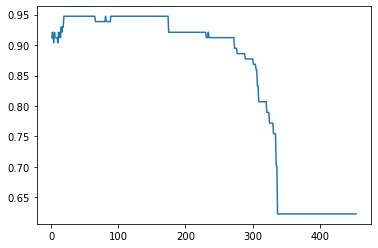

In [23]:
# ANSWER
# plot test accuracy by number of neighbors:
test_accuracy_list = []

k_range = range(1, int(training_data_rows))

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    test_accuracy_list.append(knn.score(X_test, y_test))

plt.plot(k_range,test_accuracy_list)


In [24]:
training_data_rows

455

In [25]:
k_range

range(1, 455)

### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [26]:
# ANSWER
k_range

range(1, 455)

Text(0.5, 1.0, 'Neighbors vs Mean of Cross Validation scores')

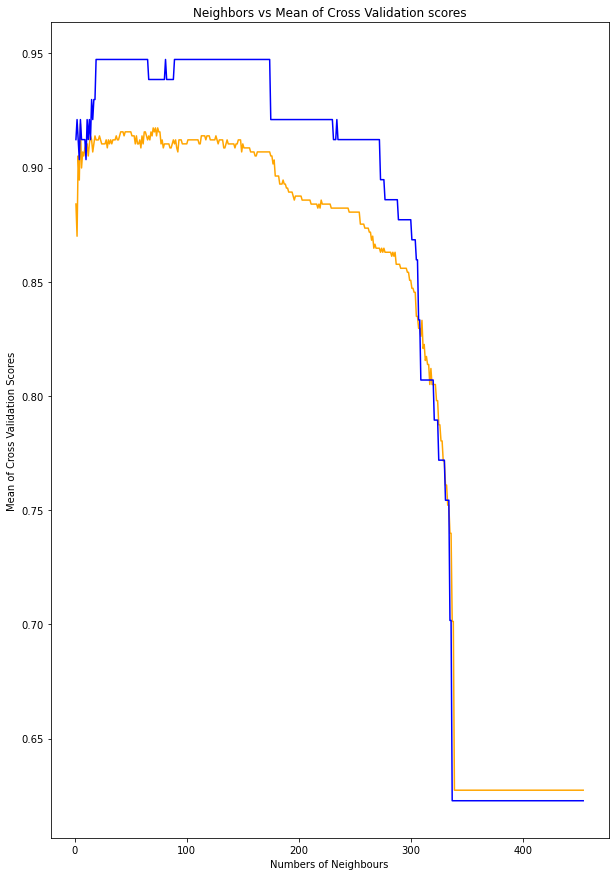

In [28]:
test_accuracy_list_cv = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_scores = cross_val_score(knn, X, y, cv = 5)
    mean_cross_val = np.mean(cv_scores)
    test_accuracy_list_cv.append(mean_cross_val)
    
    
plt.figure(figsize = (10, 15))
plt.plot(k_range, test_accuracy_list_cv, color = 'orange')
plt.plot(k_range, test_accuracy_list, color = 'blue')
plt.xlabel('Numbers of Neighbours')
plt.ylabel('Mean of Cross Validation Scores')
plt.title('Neighbors vs Mean of Cross Validation scores')

In [29]:
len(mean_cross_vals)

454

In [30]:
y_train.value_counts()

1    286
0    169
Name: Cancer, dtype: int64

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [31]:
# ANSWER
# Standarize X

scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)

    

In [32]:
cv_scores = cross_val_score(knn,standardized_X, y , cv = 5)

Text(0.5, 1.0, 'Number of Neighbors vs Mean Cross Validated Scores')

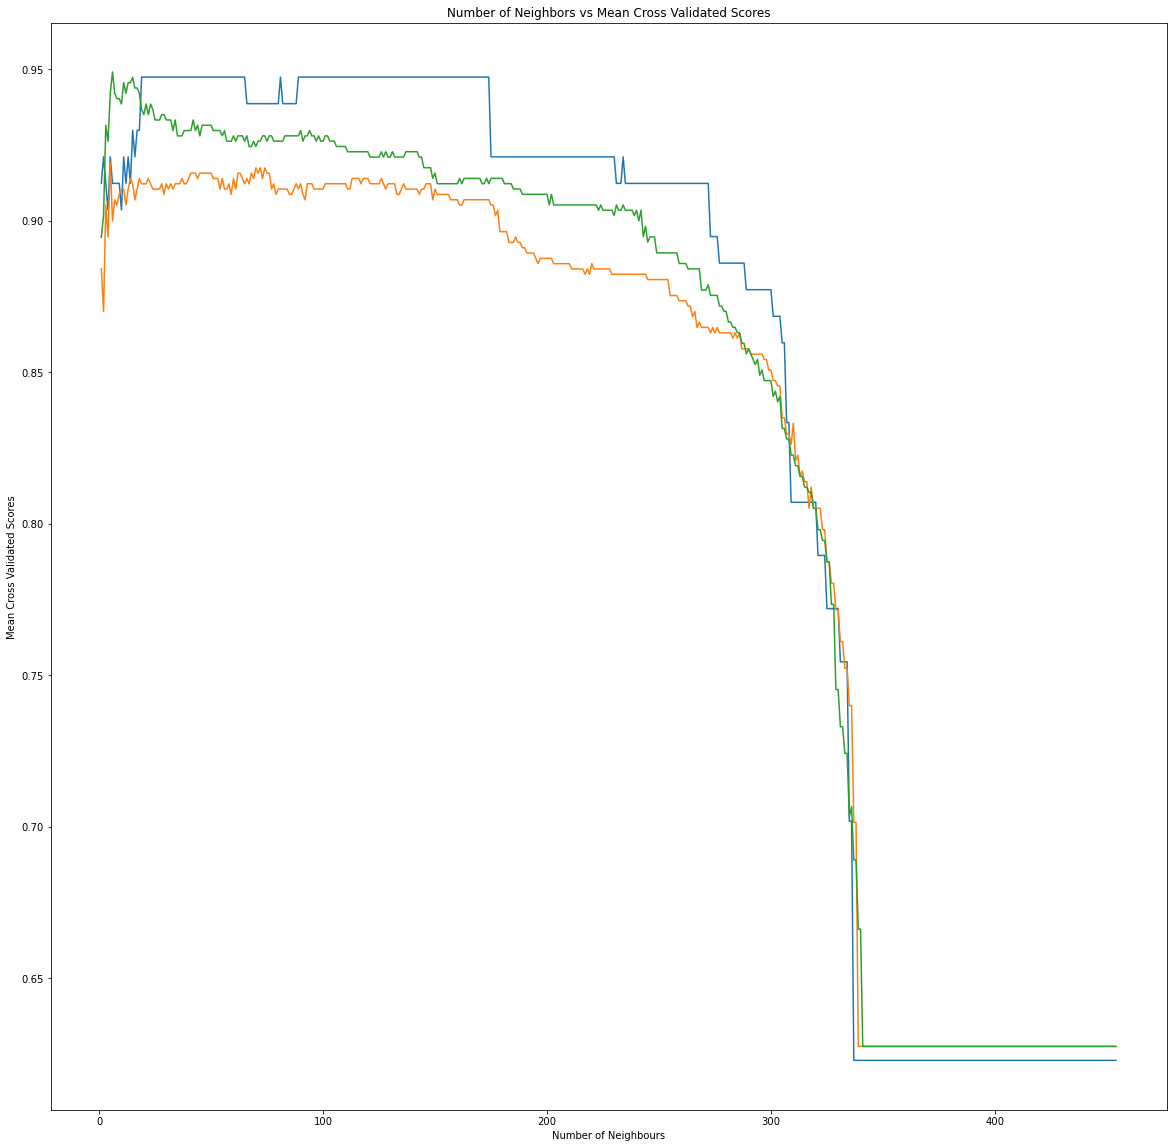

In [33]:
# ANSWER
# plot test accuracy by number of neighbors:


test_accuracy_list_cv_std = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_scores = cross_val_score(knn,standardized_X, y , cv = 5)
    standardized_mean_cross_val = np.mean(cv_scores)
    test_accuracy_list_cv_std.append(standardized_mean_cross_val)
    
    
plt.figure(figsize = (20, 20))
plt.plot(k_range, test_accuracy_list, label = 'Uncross-validated')
plt.plot(k_range, test_accuracy_list_cv, label = 'Cross Validated Unstandardized')
plt.plot(k_range, test_accuracy_list_cv_std, label = 'Cross Validated Standardized')

plt.xlabel('Number of Neighbours')
plt.ylabel('Mean Cross Validated Scores')

plt.title('Number of Neighbors vs Mean Cross Validated Scores')

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



